## brief intro

Our goal is to select the best prototypes representative of the entire data set without comprising a simple 1-Nearest Neighbor model performance. This is as an effort to reduce the high storage and computing requirements in real world settings. The two selection processes that I experiment with are random selection and label-based clustering selection. 

The random selection processes is uniformily selecting a smaller subset of the training data at random and is used to carry out the 1-Nearest Neighbors classification task. It would make more sense to obtain a richer susbet of the data if we take advantage of the labeling. The label-based clustering selection process accummulates subsets of the data under each of the labels by finding where the data is most dense.

To find where the data is most dense under each of the labels, we can carry out a KMeans routine to find these data points and 'throw away' the data that is 'noisey' (e.g far away from the clusters). If we do this for each of the labels respectively, we can combine all the clusters centers for each of the labels found by KMeans, and call those our prototypes. 


To carry out this idea I use `sklearn.cluster.MiniBatchKmeans` for clustering and `sklearn.neighbors.KNeighborsClassifier` to carry out the 1-Nearest Neighbor classification task.

### diving into code

In [1]:
import seaborn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import MiniBatchKMeans

from mnist import MNIST

% matplotlib inline
% config InlineBackend.figure_format='retina'

I use the classical MNIST mulit-class classification task (i.e classify a handwritten digit to 0-9). Using <a href="https://pypi.org/project/python-mnist/">python-mnist</a> we can easily import our training and testing data.

In [2]:
# data loader
mndata = MNIST('./python-mnist/data/')

X_train, y_train = mndata.load_training()
X_test, y_test = mndata.load_testing()

# convert into numpy objects
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

print("training set size: {}\ntesting set size: {}".format(X_train.shape, X_test.shape ))

training set size: (60000, 784)
testing set size: (10000, 784)


There's exactly $60,000$ and $10,000$ data points in the training and testing sets respectively. The data (handwritten digits) lie in a high dimensional space which will be a huge bottle neck for carring out a classification task in a production environment since for any query data point we have to compute pair-wise distances to each in every other data point in the training set. This becomes a much bigger problem as the size of the training set increases. This drawback motivates our search for prototypes! We want to reduce computation time while still maintaining model performance. 

Below is the simple prototype selector that will get us random and label-based prototypes from the data. An instance of this class will get us a subset of size $M$. 

In [3]:
class PrototypeSelector:
    """
    X: training data set
    y: training labels
    return: prototype set of size M
    """
    
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def get_prototypes(self, method, M):
        """
        method: the method to get prototypes
        M     : number of prototypes to return (size of subset)
        """
        if  method == 'random':
            indicies = np.random.permutation(self.X.shape[0])[0:M]
            return self.X[indicies,:], self.y[indicies]
      
        if method == 'label-based':            
            
            x_samples, y_samples = [], []
            for class_ in range(num_classes):
                indicies = [i for i,val in enumerate(1*self.y == class_) if val == 1]
                k_means = MiniBatchKMeans(n_clusters = int(M/10)).fit(self.X[indicies])

                x_samples.append(k_means.cluster_centers_) # use cluster centers as prototypes
                y_samples.append(self.y[indicies][0:int(M/10)])
            
        return np.concatenate(x_samples), np.concatenate(y_samples)

Crucial to the experiment is the parameter $M$, this denotes the size of the subset that will be returned through the selection process. Later in the experimentation we'll tinker with this parameter and get a sense of model performance under different subset sizes $M$. Ideally, we'd want to have the smallest size $M$ such that model performance is still 'reasonable'.


## random selection 

The random selection process is very simple: given a set of data points $X$, the `PrototypeSelector` will randomly permute the data set and return the first $M$ instances. 

## label-based selection

In short, the label-based selection method accumulates KMeans cluster centers (i.e the prototypes) under each of the labels such that the total number of cluster centers found in each label is given by 

\begin{align}
\frac{M}{\text{# of labels}}
\end{align}

If we find cluster centers independently for each of the labels (i.e there are ten digits `0-9`), we will have a prototype set of size $M$, because we would have accumulated $\frac{M}{\text{# of labels}}$ for each. We are essentially finding the same amount of prototypes under each of the labels to add into the final prototype set such that it has size $M$.


The label-based method can be summarized by the following steps:

1. For each label $i$ find the data corresponding to that label: $X_{i}$.

    2. Execute `KMeans` routine with the number of clusters set to $\frac{M}{10}$ on the data $X_{i}$
    
    3. Acculumulate these cluster centers as the prototypes

After accumulated the prototypes under each label, we should have a much better representation or prototypes, of the training data of size $M$. This method chooses prototypes where the data is most dense (i.e cluster centers) and essentially removes uninformative noise in the data set that just adds extra layer of computation to carry out a classification task. 

## experiment

Again, our goal is to find the smallest (or as small as we can) subset of the training data such that we don't comprimise the model performance of 1-nearest-neighbors classifier. In short the nearest neighbor classifier finds the label of the closest data point to a query data point and sets its prediction to that label. 

The MNIST data set has $60,000$ data points living in $784$-dimensional space. Like I mentioned earlier, we want to have a training set that is as small as we can so I experiment with subsets of size $M = 1000, 5000, 10000$. This parameter controls the size of the subsets returned by `PrototypeSelector`.

In [4]:
num_iter = 5 
num_classes = 10
M_vals = [1000, 5000,10000]

With the help of some helper functions we can get the accuracies and error bounds of the 1-nearest neighbor predictions.

In [6]:
def accuracy(y, y_pred):
    '''
    y : actual labels
    y_pred: predicted labels
    return: accuracy of model (%)
    '''
    return np.sum(1*(y_pred == y))/len(y)

def get_error_bounds(accuracies):
    '''
    accuracies: list of accuracies of model over n trials
    return: error bounds on the accuracies
    '''
    n = len(accuracies)
    t = 2.776 # 95 percent confidence interval
    mean, sigma = np.mean(accuracies), np.std(accuracies)
    bound_1 = mean + t*sigma/np.sqrt(n)
    bound_2 = mean - t*sigma/np.sqrt(n)
    
    return abs(bound_1 - bound_2)

Because of the random nature of this experiment, the number of iterations (`num_iter`) of each experiment is set to 5, so we can obtain a confidence interval on the accuracies of the model based on different subsets of size $M$ and different selection methods. We can get the error bounds using the `get_error_bounds` function and passing it a sample of model accuracies. 


Also after conducting `num_iter` on each configuration we can get a $95\%$ confidence interval on the accuracies of the model using the formula:

$$
\bar{X} \pm t\frac{s}{\sqrt{n}}
$$

Where $\bar{X}$ is the sample mean, $s$ is the sample standard deviation, and $n$ is the number of trials. The $t$ score for a problem with $n - 1 = 4$ degrees of freedom and level of significance $\alpha=0.025$ is given by $t = 2.776$. 

With the help of these two functions above we can finally carry out the experiment using `PrototypeSelector`. We first define some lists that will collect the error bounds (confidence interval) for each prototype selection method under different configurations of $M$. We also collect the accuracies of the 1-nearest neighbor model on the prototypes in order to compute average accuracy over the number of trials.

In [7]:
# error bound collector for prototype selection 
random_errs_collector = []
label_based_errs_collector = []

random_accs_collector = []
label_based_accs_collector = []

The experiment below computes prototype sets of size $M = 1000, 5000, 10000$ for a total of $n = 5$ times using `PrototypeSelector` and also obtains a 1-nearest neighbor model for prediction on the test set using the data returned from the `PrototypeSelector`. These accuracies are acculumated, and over the $n$ trials we can get the error bounds and average accuracies of the model.

In [8]:
selector = PrototypeSelector(X_train, y_train)
for M in M_vals:
    
    random_accuracies, label_based_accuracies = [], []
    for iteration in range(num_iter):    
       
        # uniformly random selected subset
        X_rand, y_rand = selector.get_prototypes('random', M)
        random_model   = KNeighborsClassifier(n_neighbors=1).fit(X_rand, y_rand)
        y_pred         = random_model.predict(X_test)
        random_accuracies.append(accuracy(y_test, y_pred))

        
        # label-based selection
        X_label_based, y_label_based  = selector.get_prototypes('label-based', M)
        prototype_model = KNeighborsClassifier(n_neighbors=1).fit(X_label_based, y_label_based)
        y_pred          = prototype_model.predict(X_test)
        label_based_accuracies.append(accuracy(y_test, y_pred))
    
    # get confidence intervals errors on accuracy
    random_errs_collector.append(get_error_bounds(random_accuracies))
    label_based_errs_collector.append(get_error_bounds(label_based_accuracies))
    
    # average accuracy over trials for each M
    random_accs_collector.append(np.mean(random_accuracies))
    label_based_accs_collector.append(np.mean(label_based_accuracies))

//anaconda/lib/python3.5/site-packages/sklearn/cluster/k_means_.py:1381: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
//anaconda/lib/python3.5/site-packages/sklearn/cluster/k_means_.py:1381: RuntimeWarning: init_size=300 should be larger than k=1000. Setting it to 3*k
  init_size=init_size)


## results

Now we have access to the results of the experiment! Particularly, we have the accuracies and error bounds of each prototype selection method (random and label-based) under different configurations of $M$ (sizes of prototype susbset) for a 1-nearest neighbor classifier.

My gut feeling tells me that a uniformily random selection of training data will not outperform the label-based selection method because we are choosing subsets that are highly represented of the data with respect to the classification task. First lets get a baseline accuracy on the complete training set. 

## baseline with full training set

The 1-nearest neighbor results using the full training set is used as a baseline for comparison in model performances from full and prototype training sets.

In [17]:
full_set_accs, full_set_errs = [], []
for i in range(num_iter):
    full_model     = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train)
    y_pred         = full_model.predict(X_test)
    curr_accuracy  = accuracy(y_test, y_pred)
    full_set_accs.append(curr_accuracy)
    
full_avg_acc = np.mean(full_set_accs)

In [21]:
full_avg_acc

0.9690999999999999

Running 1-nearest neighbor on the complete data was very computationally heavy and took **significantly** longer than the experiments themselves (didn't time them unfortunately). The final average accuracy on the complete training set:

```python
    full_avg_acc = 0.9691
```

The plot below summarizes the results of our experiments:

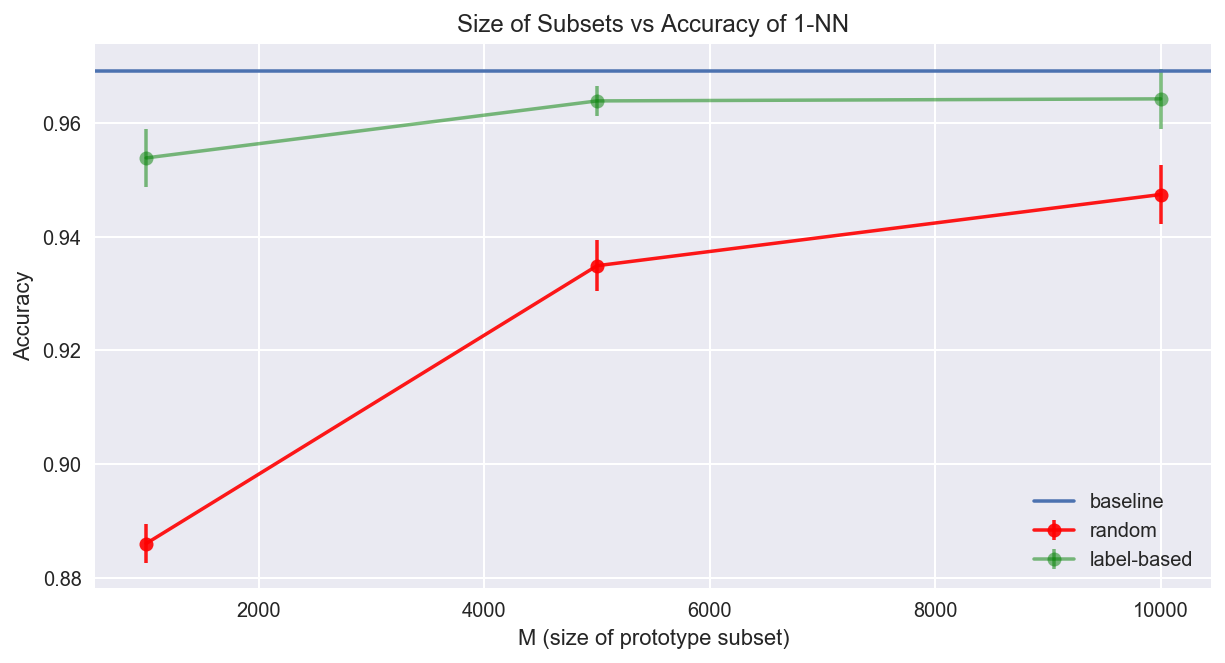

In [20]:
plt.figure(figsize=(10,5))
plt.title('Size of Subsets vs Accuracy of 1-NN')

plt.axhline(y=full_avg_acc, label='baseline')
plt.errorbar(M_vals, random_accs_collector, yerr=random_errs_collector,
             fmt='ro-', label='random', alpha=0.9)

plt.errorbar(M_vals, label_based_accs_collector, yerr=label_based_errs_collector,
             fmt='go-', label='label-based', alpha=0.5)

plt.legend(loc='lower right')
plt.xlabel('M (size of prototype subset)')
plt.ylabel('Accuracy')
plt.show()

## remarks

The label-based clustering selection method is in the same ballpark in terms of accuracy when the size of the prototype subset is $M = 10,000$. Recall that the full training set has $60,000$ data points and we were able to maintain descent model performance with just $10,000$ data points instead of using the full set!

I also make note that the random selection method would be a more competitive option if the size of the subset $M$ is significantly larger, but that would defeat our purpose of finding $M$ as small as possible. 